In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tsdt import *
from utils import *
from skmultiflow.trees import HoeffdingTreeClassifier, ExtremelyFastDecisionTreeClassifier
from skmultiflow.data import LEDGenerator
from sklearn.model_selection import KFold
from statistics import median, quantiles
from matplotlib.lines import Line2D
from time import time
import pandas as pd
import seaborn as sns
import pickle as pkl
import os

from sklearn.preprocessing import OneHotEncoder

# MONK 1

In [2]:
data_train = np.genfromtxt('../data/monks-1.train', delimiter=' ', dtype=int)
#np.random.shuffle(data_train)
data_train = data_train[:, :-1] # Getting rid of the last column, it contains only ids.
data_train = data_train[:, ::-1]

data_test = np.genfromtxt('../data/monks-1.test', delimiter=' ', dtype=int)
data_test = data_test[:, :-1] # Getting rid of the last column, it contains only ids.
data_test = data_test[:, ::-1]

labels = set(data_train[:, -1])
K = len(labels)
print('n_train : %d' %data_train.shape[0])
print('n_test : %d' %data_test.shape[0])

n_train : 124
n_test : 432


In [3]:
data = np.concatenate((data_train, data_test))
print(data.shape)

(556, 7)


In [4]:
kf = KFold(shuffle=True, random_state=256)

## Drop Last

In [5]:
encoder = OneHotEncoder(drop=np.array([3, 3, 2, 3, 4, 2][::-1]+[0]), sparse=False)
encoder.fit(data)
data_encoded = encoder.transform(data).astype(int)

### Fast-TSDT

In [6]:
n_iter = 1000
n_samples = 100
thresh_tree = -1e-6
thresh_leaf = 1e-6
thresh_mu = 0.8
thresh_sigma = 0.1
print_iter = 100
time_limit = 600
gamma = 0.75

#lambs = [0.2, 0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.001, 0.0005, 0.00025, 0.0001]
lambs = [0.1, 0.01, 0.0025, 0.0001]
times_egdt = {}
n_leaves_egdt = {}
train_acc_egdt = {}
test_acc_egdt = {}

In [7]:
for lambd in lambs:
    print('lambda = ', lambd)
    times_list = []
    n_leaves_list = []
    train_acc_list = []
    test_acc_list = []
    for i, (train_index, test_index) in enumerate(kf.split(data_encoded)):
        data_train_fold = data_encoded[train_index]
        data_test_fold = data_encoded[test_index]
        stream_generator_train = StreamGeneratorReal(data_train_fold)
        stream_generator_test = StreamGeneratorReal(data_test_fold)
        tsdt = TSDT(stream_generator_train.categories, K, 'gini')
        start_time = time()
        node, searchtree = tsdt.run(stream_generator_train, n_iter, n_samples, thresh_tree, thresh_leaf, thresh_mu, thresh_sigma, 'n_visits', lambd, gamma, print_iter, time_limit)
        totaltime = time() - start_time
        print('execution time : %.4f' %totaltime)
        times_list.append(totaltime)
        nleaves_EGDT = len(node.tree.leaves)
        print('n_leaves = ', nleaves_EGDT)
        n_leaves_list.append(nleaves_EGDT)
        trainaccu_EGDT = node.test(stream_generator_train, n=stream_generator_train.data.shape[0])
        print('train accuracy = ', trainaccu_EGDT)
        train_acc_list.append(trainaccu_EGDT)
        testaccu_EGDT = node.test(stream_generator_test, n=stream_generator_test.data.shape[0])
        print('test accuracy = ', testaccu_EGDT)
        test_acc_list.append(testaccu_EGDT)
        print('\n')
        
        # Clear the memory.
        DecisionTreeNode.id_node.clear()
        DecisionTreeNode.count = 0
    
    times_egdt[lambd] = times_list
    n_leaves_egdt[lambd] = n_leaves_list
    train_acc_egdt[lambd] = train_acc_list
    test_acc_egdt[lambd] = test_acc_list
    print('\n')
    

lambda =  0.1
iteration : 0
iteration : 100
iteration : 200
iteration : 300
iteration : 400
iteration : 500
iteration : 600
iteration : 700
iteration : 800
iteration : 900
execution time : 18.8036
n_leaves =  2
train accuracy =  0.7545045045045045
test accuracy =  0.7142857142857143


iteration : 0
iteration : 100
iteration : 200
iteration : 300
iteration : 400
iteration : 500
iteration : 600
iteration : 700
iteration : 800
iteration : 900
execution time : 19.2891
n_leaves =  2
train accuracy =  0.7348314606741573
test accuracy =  0.7927927927927928


iteration : 0
iteration : 100
iteration : 200
iteration : 300
iteration : 400
iteration : 500
iteration : 600
iteration : 700
iteration : 800
iteration : 900
execution time : 16.9004
n_leaves =  2
train accuracy =  0.7370786516853932
test accuracy =  0.7837837837837838


iteration : 0
iteration : 100
iteration : 200
iteration : 300
iteration : 400
iteration : 500
iteration : 600
iteration : 700
iteration : 800
iteration : 900
execution ti

In [8]:
with open('monk_1/times_last_tsdt.pickle', 'wb') as handle:
    pkl.dump(times_egdt, handle)
    
with open('monk_1/n_leaves_last_tsdt.pickle', 'wb') as handle:
    pkl.dump(n_leaves_egdt, handle)
    
with open('monk_1/train_acc_last_tsdt.pickle', 'wb') as handle:
    pkl.dump(train_acc_egdt, handle)
    
with open('monk_1/test_acc_last_tsdt.pickle', 'wb') as handle:
    pkl.dump(test_acc_egdt, handle)

## Drop First

In [9]:
encoder = OneHotEncoder(drop='first', sparse=False)
encoder.fit(data)
data_encoded = encoder.transform(data).astype(int)

In [11]:
n_iter = 10000
n_samples = 100
thresh_tree = -1e-6
thresh_leaf = 1e-6
thresh_mu = 0.8
thresh_sigma = 0.1
print_iter = 100
time_limit = 600
#lambd = 0.0025
gamma = 0.75

#lambs = [0.2, 0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.001, 0.0005, 0.00025, 0.0001]
lambs = [0.1, 0.01, 0.0025, 0.0001]
times_egdt = {}
n_leaves_egdt = {}
train_acc_egdt = {}
test_acc_egdt = {}

In [12]:
for lambd in lambs:
    print('lambda = ', lambd)
    times_list = []
    n_leaves_list = []
    train_acc_list = []
    test_acc_list = []
    for i, (train_index, test_index) in enumerate(kf.split(data_encoded)):
        data_train_fold = data_encoded[train_index]
        data_test_fold = data_encoded[test_index]
        stream_generator_train = StreamGeneratorReal(data_train_fold)
        stream_generator_test = StreamGeneratorReal(data_test_fold)
        tsdt = TSDT(stream_generator_train.categories, K, 'gini')
        start_time = time()
        node, searchtree = tsdt.run(stream_generator_train, n_iter, n_samples, thresh_tree, thresh_leaf, thresh_mu, thresh_sigma, 'n_visits', lambd, gamma, print_iter, time_limit)
        totaltime = time() - start_time
        print('execution time : %.4f' %totaltime)
        times_list.append(totaltime)
        nleaves_EGDT = len(node.tree.leaves)
        print('n_leaves = ', nleaves_EGDT)
        n_leaves_list.append(nleaves_EGDT)
        trainaccu_EGDT = node.test(stream_generator_train, n=stream_generator_train.data.shape[0])
        print('train accuracy = ', trainaccu_EGDT)
        train_acc_list.append(trainaccu_EGDT)
        testaccu_EGDT = node.test(stream_generator_test, n=stream_generator_test.data.shape[0])
        print('test accuracy = ', testaccu_EGDT)
        test_acc_list.append(testaccu_EGDT)
        print('\n')
        
        # Clear the memory.
        DecisionTreeNode.id_node.clear()
        DecisionTreeNode.count = 0
    
    times_egdt[lambd] = times_list
    n_leaves_egdt[lambd] = n_leaves_list
    train_acc_egdt[lambd] = train_acc_list
    test_acc_egdt[lambd] = test_acc_list
    print('\n')
    

lambda =  0.1
iteration : 0
iteration : 100
iteration : 200
iteration : 300
iteration : 400
iteration : 500
iteration : 600
iteration : 700
iteration : 800
iteration : 900
iteration : 1000
iteration : 1100
iteration : 1200
iteration : 1300
iteration : 1400
iteration : 1500
iteration : 1600
iteration : 1700
iteration : 1800
iteration : 1900
iteration : 2000
iteration : 2100
iteration : 2200
iteration : 2300
iteration : 2400
iteration : 2500
iteration : 2600
iteration : 2700
iteration : 2800
iteration : 2900
iteration : 3000
iteration : 3100
iteration : 3200
iteration : 3300
iteration : 3400
iteration : 3500
iteration : 3600
iteration : 3700
iteration : 3800
iteration : 3900
iteration : 4000
iteration : 4100
iteration : 4200
iteration : 4300
iteration : 4400
iteration : 4500
iteration : 4600
iteration : 4700
iteration : 4800
iteration : 4900
iteration : 5000
iteration : 5100
iteration : 5200
iteration : 5300
iteration : 5400
iteration : 5500
iteration : 5600
iteration : 5700
iteration : 

In [13]:
with open('monk_1/times_first_tsdt.pickle', 'wb') as handle:
    pkl.dump(times_egdt, handle)
    
with open('monk_1/n_leaves_first_tsdt.pickle', 'wb') as handle:
    pkl.dump(n_leaves_egdt, handle)
    
with open('monk_1/train_acc_first_tsdt.pickle', 'wb') as handle:
    pkl.dump(train_acc_egdt, handle)
    
with open('monk_1/test_acc_first_tsdt.pickle', 'wb') as handle:
    pkl.dump(test_acc_egdt, handle)

## Original

In [14]:
n_iter = 1000
n_samples = 100
thresh_tree = -1e-6
thresh_leaf = 1e-6
thresh_mu = 0.8
thresh_sigma = 0.1
print_iter = 100
time_limit = 600
#lambd = 0.0025
gamma = 0.75

#lambs = [0.2, 0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.001, 0.0005, 0.00025, 0.0001]
lambs = [0.1, 0.01, 0.0025, 0.0001]
times_egdt = {}
n_leaves_egdt = {}
train_acc_egdt = {}
test_acc_egdt = {}

In [15]:
for lambd in lambs:
    print('lambda = ', lambd)
    times_list = []
    n_leaves_list = []
    train_acc_list = []
    test_acc_list = []
    for i, (train_index, test_index) in enumerate(kf.split(data)):
        data_train_fold = data[train_index]
        data_test_fold = data[test_index]
        stream_generator_train = StreamGeneratorReal(data_train_fold)
        stream_generator_test = StreamGeneratorReal(data_test_fold)
        tsdt = TSDT(stream_generator_train.categories, K, 'gini')
        start_time = time()
        node, searchtree = tsdt.run(stream_generator_train, n_iter, n_samples, thresh_tree, thresh_leaf, thresh_mu, thresh_sigma, 'n_visits', lambd, gamma, print_iter, time_limit)
        totaltime = time() - start_time
        print('execution time : %.4f' %totaltime)
        times_list.append(totaltime)
        nleaves_EGDT = len(node.tree.leaves)
        print('n_leaves = ', nleaves_EGDT)
        n_leaves_list.append(nleaves_EGDT)
        trainaccu_EGDT = node.test(stream_generator_train, n=stream_generator_train.data.shape[0])
        print('train accuracy = ', trainaccu_EGDT)
        train_acc_list.append(trainaccu_EGDT)
        testaccu_EGDT = node.test(stream_generator_test, n=stream_generator_test.data.shape[0])
        print('test accuracy = ', testaccu_EGDT)
        test_acc_list.append(testaccu_EGDT)
        print('\n')
        
        # Clear the memory.
        DecisionTreeNode.id_node.clear()
        DecisionTreeNode.count = 0
    
    times_egdt[lambd] = times_list
    n_leaves_egdt[lambd] = n_leaves_list
    train_acc_egdt[lambd] = train_acc_list
    test_acc_egdt[lambd] = test_acc_list
    print('\n')
    

lambda =  0.1
iteration : 0
iteration : 100
iteration : 200
iteration : 300
iteration : 400
iteration : 500
iteration : 600
iteration : 700
iteration : 800
iteration : 900
execution time : 15.9957
n_leaves =  4
train accuracy =  0.7545045045045045
test accuracy =  0.7142857142857143


iteration : 0
iteration : 100
iteration : 200
iteration : 300
iteration : 400
iteration : 500
iteration : 600
iteration : 700
iteration : 800
iteration : 900
execution time : 16.2583
n_leaves =  4
train accuracy =  0.7348314606741573
test accuracy =  0.7927927927927928


iteration : 0
iteration : 100
iteration : 200
iteration : 300
iteration : 400
iteration : 500
iteration : 600
iteration : 700
iteration : 800
iteration : 900
execution time : 16.5719
n_leaves =  4
train accuracy =  0.7370786516853932
test accuracy =  0.7837837837837838


iteration : 0
iteration : 100
iteration : 200
iteration : 300
iteration : 400
iteration : 500
iteration : 600
iteration : 700
iteration : 800
iteration : 900
execution ti

In [16]:
with open('monk_1/times_original_tsdt.pickle', 'wb') as handle:
    pkl.dump(times_egdt, handle)
    
with open('monk_1/n_leaves_original_tsdt.pickle', 'wb') as handle:
    pkl.dump(n_leaves_egdt, handle)
    
with open('monk_1/train_acc_original_tsdt.pickle', 'wb') as handle:
    pkl.dump(train_acc_egdt, handle)
    
with open('monk_1/test_acc_original_tsdt.pickle', 'wb') as handle:
    pkl.dump(test_acc_egdt, handle)

# Monk 2

In [3]:
file = '../data/monk2-train.csv'
data = pd.DataFrame(pd.read_csv(file, sep=";")).values
#np.random.shuffle(data)
labels = set(data[:, -1])
K = len(labels)
print(data.shape)

(169, 12)


In [18]:
kf = KFold(shuffle=True, random_state=256)

In [19]:
n_iter = 10000
n_samples = 100
thresh_tree = -1e-6
thresh_leaf = 1e-6
thresh_mu = 0.8
thresh_sigma = 0.1
print_iter = 100
time_limit = 600
#lambd = 0.0025
gamma = 0.75

#lambs = [0.2, 0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.001, 0.0005, 0.00025, 0.0001]
lambs = [0.1, 0.01, 0.0025, 0.0001]
times_egdt = {}
n_leaves_egdt = {}
train_acc_egdt = {}
test_acc_egdt = {}

In [20]:
for lambd in lambs:
    print('lambda = ', lambd)
    times_list = []
    n_leaves_list = []
    train_acc_list = []
    test_acc_list = []
    for i, (train_index, test_index) in enumerate(kf.split(data)):
        data_train_fold = data[train_index]
        data_test_fold = data[test_index]
        stream_generator_train = StreamGeneratorReal(data_train_fold)
        stream_generator_test = StreamGeneratorReal(data_test_fold)
        tsdt = TSDT(stream_generator_train.categories, K, 'gini')
        start_time = time()
        node, searchtree = tsdt.run(stream_generator_train, n_iter, n_samples, thresh_tree, thresh_leaf, thresh_mu, thresh_sigma, 'n_visits', lambd, gamma, print_iter, time_limit)
        totaltime = time() - start_time
        print('execution time : %.4f' %totaltime)
        times_list.append(totaltime)
        nleaves_EGDT = len(node.tree.leaves)
        print('n_leaves = ', nleaves_EGDT)
        n_leaves_list.append(nleaves_EGDT)
        trainaccu_EGDT = node.test(stream_generator_train, n=stream_generator_train.data.shape[0])
        print('train accuracy = ', trainaccu_EGDT)
        train_acc_list.append(trainaccu_EGDT)
        testaccu_EGDT = node.test(stream_generator_test, n=stream_generator_test.data.shape[0])
        print('test accuracy = ', testaccu_EGDT)
        test_acc_list.append(testaccu_EGDT)
        print('\n')
        
        # Clear the memory.
        DecisionTreeNode.id_node.clear()
        DecisionTreeNode.count = 0
    
    times_egdt[lambd] = times_list
    n_leaves_egdt[lambd] = n_leaves_list
    train_acc_egdt[lambd] = train_acc_list
    test_acc_egdt[lambd] = test_acc_list
    print('\n')

lambda =  0.1
iteration : 0
iteration : 100
iteration : 200
iteration : 300
iteration : 400
iteration : 500
iteration : 600
iteration : 700
iteration : 800
iteration : 900
iteration : 1000
iteration : 1100
iteration : 1200
iteration : 1300
iteration : 1400
iteration : 1500
iteration : 1600
iteration : 1700
iteration : 1800
iteration : 1900
iteration : 2000
iteration : 2100
iteration : 2200
iteration : 2300
iteration : 2400
iteration : 2500
iteration : 2600
iteration : 2700
iteration : 2800
iteration : 2900
iteration : 3000
iteration : 3100
iteration : 3200
iteration : 3300
iteration : 3400
iteration : 3500
iteration : 3600
iteration : 3700
iteration : 3800
iteration : 3900
iteration : 4000
iteration : 4100
iteration : 4200
iteration : 4300
iteration : 4400
iteration : 4500
iteration : 4600
iteration : 4700
iteration : 4800
iteration : 4900
iteration : 5000
iteration : 5100
iteration : 5200
iteration : 5300
iteration : 5400
iteration : 5500
iteration : 5600
iteration : 5700
iteration : 

In [21]:
with open('monk_2/times_tsdt.pickle', 'wb') as handle:
    pkl.dump(times_egdt, handle)
    
with open('monk_2/n_leaves_tsdt.pickle', 'wb') as handle:
    pkl.dump(n_leaves_egdt, handle)
    
with open('monk_2/train_acc_tsdt.pickle', 'wb') as handle:
    pkl.dump(train_acc_egdt, handle)
    
with open('monk_2/test_acc_tsdt.pickle', 'wb') as handle:
    pkl.dump(test_acc_egdt, handle)

# Monk 3

In [4]:
file = '../data/monk3-train.csv'
data = pd.DataFrame(pd.read_csv(file, sep=";")).values
#np.random.shuffle(data)
labels = set(data[:, -1])
K = len(labels)
print(data.shape)

(122, 12)


In [23]:
kf = KFold(shuffle=True, random_state=256)

In [24]:
n_iter = 10000
n_samples = 100
thresh_tree = -1e-6
thresh_leaf = 1e-6
thresh_mu = 0.8
thresh_sigma = 0.1
print_iter = 100
time_limit = 600
#lambd = 0.0025
gamma = 0.75

#lambs = [0.2, 0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.001, 0.0005, 0.00025, 0.0001]
lambs = [0.1, 0.01, 0.0025, 0.0001]
times_egdt = {}
n_leaves_egdt = {}
train_acc_egdt = {}
test_acc_egdt = {}

In [25]:
for lambd in lambs:
    print('lambda = ', lambd)
    times_list = []
    n_leaves_list = []
    train_acc_list = []
    test_acc_list = []
    for i, (train_index, test_index) in enumerate(kf.split(data)):
        data_train_fold = data[train_index]
        data_test_fold = data[test_index]
        stream_generator_train = StreamGeneratorReal(data_train_fold)
        stream_generator_test = StreamGeneratorReal(data_test_fold)
        tsdt = TSDT(stream_generator_train.categories, K, 'gini')
        start_time = time()
        node, searchtree = tsdt.run(stream_generator_train, n_iter, n_samples, thresh_tree, thresh_leaf, thresh_mu, thresh_sigma, 'n_visits', lambd, gamma, print_iter, time_limit)
        totaltime = time() - start_time
        print('execution time : %.4f' %totaltime)
        times_list.append(totaltime)
        nleaves_EGDT = len(node.tree.leaves)
        print('n_leaves = ', nleaves_EGDT)
        n_leaves_list.append(nleaves_EGDT)
        trainaccu_EGDT = node.test(stream_generator_train, n=stream_generator_train.data.shape[0])
        print('train accuracy = ', trainaccu_EGDT)
        train_acc_list.append(trainaccu_EGDT)
        testaccu_EGDT = node.test(stream_generator_test, n=stream_generator_test.data.shape[0])
        print('test accuracy = ', testaccu_EGDT)
        test_acc_list.append(testaccu_EGDT)
        print('\n')
        
        # Clear the memory.
        DecisionTreeNode.id_node.clear()
        DecisionTreeNode.count = 0
    
    times_egdt[lambd] = times_list
    n_leaves_egdt[lambd] = n_leaves_list
    train_acc_egdt[lambd] = train_acc_list
    test_acc_egdt[lambd] = test_acc_list
    print('\n')

lambda =  0.1
iteration : 0
iteration : 100
iteration : 200
iteration : 300
iteration : 400
iteration : 500
iteration : 600
iteration : 700
iteration : 800
iteration : 900
iteration : 1000
iteration : 1100
iteration : 1200
iteration : 1300
iteration : 1400
iteration : 1500
iteration : 1600
iteration : 1700
iteration : 1800
iteration : 1900
iteration : 2000
iteration : 2100
iteration : 2200
iteration : 2300
iteration : 2400
iteration : 2500
iteration : 2600
iteration : 2700
iteration : 2800
iteration : 2900
iteration : 3000
iteration : 3100
iteration : 3200
iteration : 3300
iteration : 3400
iteration : 3500
iteration : 3600
iteration : 3700
iteration : 3800
iteration : 3900
iteration : 4000
iteration : 4100
iteration : 4200
iteration : 4300
iteration : 4400
iteration : 4500
iteration : 4600
iteration : 4700
iteration : 4800
iteration : 4900
iteration : 5000
iteration : 5100
iteration : 5200
iteration : 5300
iteration : 5400
iteration : 5500
iteration : 5600
iteration : 5700
iteration : 

In [28]:
with open('monk_3/times_tsdt.pickle', 'wb') as handle:
    pkl.dump(times_egdt, handle)
    
with open('monk_3/n_leaves_tsdt.pickle', 'wb') as handle:
    pkl.dump(n_leaves_egdt, handle)
    
with open('monk_3/train_acc_tsdt.pickle', 'wb') as handle:
    pkl.dump(train_acc_egdt, handle)
    
with open('monk_3/test_acc_tsdt.pickle', 'wb') as handle:
    pkl.dump(test_acc_egdt, handle)

# Tic-Tac-Toe

In [5]:
file = '../data/tic-tac-toe.csv'
data = pd.DataFrame(pd.read_csv(file, sep=";")).values
np.random.shuffle(data)
labels = set(data[:, -1])
K = len(labels)
print(data.shape)

(958, 19)


In [3]:
kf = KFold(shuffle=True, random_state=256)

In [4]:
n_iter = 10000
n_samples = 100
thresh_tree = -1e-6
thresh_leaf = 1e-6
thresh_mu = 0.8
thresh_sigma = 0.1
print_iter = 100
time_limit = 600
#lambd = 0.0025
gamma = 0.75
#gamma = 1

#lambs = [0.2, 0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.001, 0.0005, 0.00025, 0.0001]
lambs = [0.1, 0.01, 0.0025, 0.0001]
times_egdt = {}
n_leaves_egdt = {}
train_acc_egdt = {}
test_acc_egdt = {}

In [5]:
for lambd in lambs:
    print('lambda = ', lambd)
    times_list = []
    n_leaves_list = []
    train_acc_list = []
    test_acc_list = []
    for i, (train_index, test_index) in enumerate(kf.split(data)):
        data_train_fold = data[train_index]
        data_test_fold = data[test_index]
        stream_generator_train = StreamGeneratorReal(data_train_fold)
        stream_generator_test = StreamGeneratorReal(data_test_fold)
        tsdt = TSDT(stream_generator_train.categories, K, 'gini')
        start_time = time()
        node, searchtree = tsdt.run(stream_generator_train, n_iter, n_samples, thresh_tree, thresh_leaf, thresh_mu, thresh_sigma, 'n_visits', lambd, gamma, print_iter, time_limit)
        totaltime = time() - start_time
        print('execution time : %.4f' %totaltime)
        times_list.append(totaltime)
        nleaves_EGDT = len(node.tree.leaves)
        print('n_leaves = ', nleaves_EGDT)
        n_leaves_list.append(nleaves_EGDT)
        trainaccu_EGDT = node.test(stream_generator_train, n=stream_generator_train.data.shape[0])
        print('train accuracy = ', trainaccu_EGDT)
        train_acc_list.append(trainaccu_EGDT)
        testaccu_EGDT = node.test(stream_generator_test, n=stream_generator_test.data.shape[0])
        print('test accuracy = ', testaccu_EGDT)
        test_acc_list.append(testaccu_EGDT)
        print('\n')
        
        # Clear the memory.
        DecisionTreeNode.id_node.clear()
        DecisionTreeNode.count = 0
    
    times_egdt[lambd] = times_list
    n_leaves_egdt[lambd] = n_leaves_list
    train_acc_egdt[lambd] = train_acc_list
    test_acc_egdt[lambd] = test_acc_list
    print('\n')

lambda =  0.1
iteration : 0
iteration : 100
iteration : 200
iteration : 300
iteration : 400
iteration : 500
iteration : 600
iteration : 700
iteration : 800
iteration : 900
iteration : 1000
iteration : 1100
iteration : 1200
iteration : 1300
iteration : 1400
iteration : 1500
iteration : 1600
iteration : 1700
iteration : 1800
iteration : 1900
iteration : 2000
iteration : 2100
iteration : 2200
iteration : 2300
iteration : 2400
iteration : 2500
iteration : 2600
iteration : 2700
iteration : 2800
iteration : 2900
iteration : 3000
iteration : 3100
iteration : 3200
iteration : 3300
iteration : 3400
iteration : 3500
iteration : 3600
iteration : 3700
iteration : 3800
iteration : 3900
iteration : 4000
iteration : 4100
iteration : 4200
iteration : 4300
iteration : 4400
iteration : 4500
iteration : 4600
iteration : 4700
iteration : 4800
iteration : 4900
iteration : 5000
iteration : 5100
iteration : 5200
iteration : 5300
iteration : 5400
iteration : 5500
iteration : 5600
iteration : 5700
iteration : 

In [6]:
with open('tic-tac-toe/times_tsdt.pickle', 'wb') as handle:
    pkl.dump(times_egdt, handle)
    
with open('tic-tac-toe/n_leaves_tsdt.pickle', 'wb') as handle:
    pkl.dump(n_leaves_egdt, handle)
    
with open('tic-tac-toe/train_acc_tsdt.pickle', 'wb') as handle:
    pkl.dump(train_acc_egdt, handle)
    
with open('tic-tac-toe/test_acc_tsdt.pickle', 'wb') as handle:
    pkl.dump(test_acc_egdt, handle)

# Car Evaluation

In [6]:
file = '../data/car-evaluation.csv'
data = pd.DataFrame(pd.read_csv(file, sep=";")).values
np.random.shuffle(data)
labels = set(data[:, -1])
K = len(labels)
print(data.shape)

(1728, 16)


In [8]:
kf = KFold(shuffle=True, random_state=256)

In [9]:
n_iter = 10000
n_samples = 100
thresh_tree = -1e-6
thresh_leaf = 1e-6
thresh_mu = 0.8
thresh_sigma = 0.1
print_iter = 100
time_limit = 600
#lambd = 0.0025
gamma = 1

#lambs = [0.2, 0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.001, 0.0005, 0.00025, 0.0001]
lambs = [0.1, 0.01, 0.0025, 0.0001]
times_egdt = {}
n_leaves_egdt = {}
train_acc_egdt = {}
test_acc_egdt = {}

In [10]:
for lambd in lambs:
    print('lambda = ', lambd)
    times_list = []
    n_leaves_list = []
    train_acc_list = []
    test_acc_list = []
    for i, (train_index, test_index) in enumerate(kf.split(data)):
        data_train_fold = data[train_index]
        data_test_fold = data[test_index]
        stream_generator_train = StreamGeneratorReal(data_train_fold)
        stream_generator_test = StreamGeneratorReal(data_test_fold)
        tsdt = TSDT(stream_generator_train.categories, K, 'gini')
        start_time = time()
        node, searchtree = tsdt.run(stream_generator_train, n_iter, n_samples, thresh_tree, thresh_leaf, thresh_mu, thresh_sigma, 'n_visits', lambd, gamma, print_iter, time_limit)
        totaltime = time() - start_time
        print('execution time : %.4f' %totaltime)
        times_list.append(totaltime)
        nleaves_EGDT = len(node.tree.leaves)
        print('n_leaves = ', nleaves_EGDT)
        n_leaves_list.append(nleaves_EGDT)
        trainaccu_EGDT = node.test(stream_generator_train, n=stream_generator_train.data.shape[0])
        print('train accuracy = ', trainaccu_EGDT)
        train_acc_list.append(trainaccu_EGDT)
        testaccu_EGDT = node.test(stream_generator_test, n=stream_generator_test.data.shape[0])
        print('test accuracy = ', testaccu_EGDT)
        test_acc_list.append(testaccu_EGDT)
        print('\n')
        
        # Clear the memory.
        DecisionTreeNode.id_node.clear()
        DecisionTreeNode.count = 0
    
    times_egdt[lambd] = times_list
    n_leaves_egdt[lambd] = n_leaves_list
    train_acc_egdt[lambd] = train_acc_list
    test_acc_egdt[lambd] = test_acc_list
    print('\n')

lambda =  0.1
iteration : 0
iteration : 100
iteration : 200
iteration : 300
iteration : 400
iteration : 500
iteration : 600
iteration : 700
iteration : 800
iteration : 900
iteration : 1000
iteration : 1100
iteration : 1200
iteration : 1300
iteration : 1400
iteration : 1500
iteration : 1600
iteration : 1700
iteration : 1800
iteration : 1900
iteration : 2000
iteration : 2100
iteration : 2200
iteration : 2300
iteration : 2400
iteration : 2500
iteration : 2600
iteration : 2700
iteration : 2800
iteration : 2900
iteration : 3000
iteration : 3100
iteration : 3200
iteration : 3300
iteration : 3400
iteration : 3500
iteration : 3600
iteration : 3700
iteration : 3800
iteration : 3900
iteration : 4000
iteration : 4100
iteration : 4200
iteration : 4300
iteration : 4400
iteration : 4500
iteration : 4600
iteration : 4700
iteration : 4800
iteration : 4900
iteration : 5000
iteration : 5100
iteration : 5200
iteration : 5300
iteration : 5400
iteration : 5500
iteration : 5600
iteration : 5700
iteration : 

In [11]:
with open('car-evaluation/times_tsdt_gamma1.pickle', 'wb') as handle:
    pkl.dump(times_egdt, handle)
    
with open('car-evaluation/n_leaves_tsdt_gamma1.pickle', 'wb') as handle:
    pkl.dump(n_leaves_egdt, handle)
    
with open('car-evaluation/train_acc_tsdt_gamma1.pickle', 'wb') as handle:
    pkl.dump(train_acc_egdt, handle)
    
with open('car-evaluation/test_acc_tsdt_gamma1.pickle', 'wb') as handle:
    pkl.dump(test_acc_egdt, handle)

# COMPAS

In [7]:
file = '../data/compas-binary.csv'
data = pd.DataFrame(pd.read_csv(file, sep=";")).values
np.random.shuffle(data)
labels = set(data[:, -1])
K = len(labels)
print(data.shape)

(6907, 13)


In [13]:
kf = KFold(shuffle=True, random_state=256)

In [14]:
n_iter = 10000
n_samples = 100
thresh_tree = -1e-6
thresh_leaf = 1e-6
thresh_mu = 0.8
thresh_sigma = 0.1
print_iter = 100
time_limit = 600
#lambd = 0.0025
#gamma = 0.75
gamma = 1

#lambs = [0.2, 0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.001, 0.0005, 0.00025, 0.0001]
lambs = [0.1, 0.01, 0.0025, 0.0001]
times_egdt = {}
n_leaves_egdt = {}
train_acc_egdt = {}
test_acc_egdt = {}

In [15]:
for lambd in lambs:
    print('lambda = ', lambd)
    times_list = []
    n_leaves_list = []
    train_acc_list = []
    test_acc_list = []
    for i, (train_index, test_index) in enumerate(kf.split(data)):
        data_train_fold = data[train_index]
        data_test_fold = data[test_index]
        stream_generator_train = StreamGeneratorReal(data_train_fold)
        stream_generator_test = StreamGeneratorReal(data_test_fold)
        tsdt = TSDT(stream_generator_train.categories, K, 'gini')
        start_time = time()
        node, searchtree = tsdt.run(stream_generator_train, n_iter, n_samples, thresh_tree, thresh_leaf, thresh_mu, thresh_sigma, 'n_visits', lambd, gamma, print_iter, time_limit)
        totaltime = time() - start_time
        print('execution time : %.4f' %totaltime)
        times_list.append(totaltime)
        nleaves_EGDT = len(node.tree.leaves)
        print('n_leaves = ', nleaves_EGDT)
        n_leaves_list.append(nleaves_EGDT)
        trainaccu_EGDT = node.test(stream_generator_train, n=stream_generator_train.data.shape[0])
        print('train accuracy = ', trainaccu_EGDT)
        train_acc_list.append(trainaccu_EGDT)
        testaccu_EGDT = node.test(stream_generator_test, n=stream_generator_test.data.shape[0])
        print('test accuracy = ', testaccu_EGDT)
        test_acc_list.append(testaccu_EGDT)
        print('\n')
        
        # Clear the memory.
        DecisionTreeNode.id_node.clear()
        DecisionTreeNode.count = 0
    
    times_egdt[lambd] = times_list
    n_leaves_egdt[lambd] = n_leaves_list
    train_acc_egdt[lambd] = train_acc_list
    test_acc_egdt[lambd] = test_acc_list
    print('\n')

lambda =  0.1
iteration : 0
iteration : 100
iteration : 200
iteration : 300
iteration : 400
iteration : 500
iteration : 600
iteration : 700
iteration : 800
iteration : 900
iteration : 1000
iteration : 1100
iteration : 1200
iteration : 1300
iteration : 1400
iteration : 1500
iteration : 1600
iteration : 1700
iteration : 1800
iteration : 1900
iteration : 2000
iteration : 2100
iteration : 2200
iteration : 2300
iteration : 2400
iteration : 2500
iteration : 2600
iteration : 2700
iteration : 2800
iteration : 2900
iteration : 3000
iteration : 3100
iteration : 3200
iteration : 3300
iteration : 3400
iteration : 3500
iteration : 3600
iteration : 3700
iteration : 3800
iteration : 3900
iteration : 4000
iteration : 4100
iteration : 4200
iteration : 4300
iteration : 4400
iteration : 4500
iteration : 4600
iteration : 4700
iteration : 4800
iteration : 4900
iteration : 5000
iteration : 5100
iteration : 5200
iteration : 5300
iteration : 5400
iteration : 5500
iteration : 5600
iteration : 5700
iteration : 

In [16]:
with open('compas/times_tsdt_gamma1.pickle', 'wb') as handle:
    pkl.dump(times_egdt, handle)
    
with open('compas/n_leaves_tsdt_gamma1.pickle', 'wb') as handle:
    pkl.dump(n_leaves_egdt, handle)
    
with open('compas/train_acc_tsdt_gamma1.pickle', 'wb') as handle:
    pkl.dump(train_acc_egdt, handle)
    
with open('compas/test_acc_tsdt_gamma1.pickle', 'wb') as handle:
    pkl.dump(test_acc_egdt, handle)

# FICO

In [8]:
file = '../data/fico_binary.csv'
data = pd.DataFrame(pd.read_csv(file, sep=";")).values
np.random.shuffle(data)
labels = set(data[:, -1])
K = len(labels)
print(data.shape)

(10459, 18)


In [18]:
kf = KFold(shuffle=True, random_state=256)

In [19]:
n_iter = 10000
n_samples = 100
thresh_tree = -1e-6
thresh_leaf = 1e-6
thresh_mu = 0.8
thresh_sigma = 0.1
print_iter = 100
time_limit = 600
#lambd = 0.0025
#gamma = 0.75
gamma = 1

#lambs = [0.2, 0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.001, 0.0005, 0.00025, 0.0001]
lambs = [0.1, 0.01, 0.0025, 0.0001]
times_egdt = {}
n_leaves_egdt = {}
train_acc_egdt = {}
test_acc_egdt = {}

In [20]:
for lambd in lambs:
    print('lambda = ', lambd)
    times_list = []
    n_leaves_list = []
    train_acc_list = []
    test_acc_list = []
    for i, (train_index, test_index) in enumerate(kf.split(data)):
        data_train_fold = data[train_index]
        data_test_fold = data[test_index]
        stream_generator_train = StreamGeneratorReal(data_train_fold)
        stream_generator_test = StreamGeneratorReal(data_test_fold)
        tsdt = TSDT(stream_generator_train.categories, K, 'gini')
        start_time = time()
        node, searchtree = tsdt.run(stream_generator_train, n_iter, n_samples, thresh_tree, thresh_leaf, thresh_mu, thresh_sigma, 'n_visits', lambd, gamma, print_iter, time_limit)
        totaltime = time() - start_time
        print('execution time : %.4f' %totaltime)
        times_list.append(totaltime)
        nleaves_EGDT = len(node.tree.leaves)
        print('n_leaves = ', nleaves_EGDT)
        n_leaves_list.append(nleaves_EGDT)
        trainaccu_EGDT = node.test(stream_generator_train, n=stream_generator_train.data.shape[0])
        print('train accuracy = ', trainaccu_EGDT)
        train_acc_list.append(trainaccu_EGDT)
        testaccu_EGDT = node.test(stream_generator_test, n=stream_generator_test.data.shape[0])
        print('test accuracy = ', testaccu_EGDT)
        test_acc_list.append(testaccu_EGDT)
        print('\n')
        
        # Clear the memory.
        DecisionTreeNode.id_node.clear()
        DecisionTreeNode.count = 0
    
    times_egdt[lambd] = times_list
    n_leaves_egdt[lambd] = n_leaves_list
    train_acc_egdt[lambd] = train_acc_list
    test_acc_egdt[lambd] = test_acc_list
    print('\n')

lambda =  0.1
iteration : 0
iteration : 100
iteration : 200
iteration : 300
iteration : 400
iteration : 500
iteration : 600
iteration : 700
iteration : 800
iteration : 900
iteration : 1000
iteration : 1100
iteration : 1200
iteration : 1300
iteration : 1400
iteration : 1500
iteration : 1600
iteration : 1700
iteration : 1800
iteration : 1900
iteration : 2000
iteration : 2100
iteration : 2200
iteration : 2300
iteration : 2400
iteration : 2500
iteration : 2600
iteration : 2700
iteration : 2800
iteration : 2900
iteration : 3000
iteration : 3100
iteration : 3200
iteration : 3300
iteration : 3400
iteration : 3500
iteration : 3600
iteration : 3700
iteration : 3800
iteration : 3900
iteration : 4000
iteration : 4100
iteration : 4200
iteration : 4300
iteration : 4400
iteration : 4500
iteration : 4600
iteration : 4700
iteration : 4800
iteration : 4900
iteration : 5000
iteration : 5100
iteration : 5200
iteration : 5300
iteration : 5400
iteration : 5500
iteration : 5600
iteration : 5700
iteration : 

In [22]:
with open('fico/times_tsdt.pickle', 'wb') as handle:
    pkl.dump(times_egdt, handle)
    
with open('fico/n_leaves_tsdt.pickle', 'wb') as handle:
    pkl.dump(n_leaves_egdt, handle)
    
with open('fico/train_acc_tsdt.pickle', 'wb') as handle:
    pkl.dump(train_acc_egdt, handle)
    
with open('fico/test_acc_tsdt.pickle', 'wb') as handle:
    pkl.dump(test_acc_egdt, handle)

# Summary

In [10]:
algs = ['dl85', 'osdt', 'fasttsdt']
res = ['n_leaves', 'train_acc', 'test_acc', 'times']

In [11]:
def construct(prob, data):
    d = {'dl85' : {}, 'osdt' : {}, 'fasttsdt' : {}}

    for result in res:
        d['dl85'][result] = {}
        for depth in depths:
            d['dl85'][result][depth] = quantiles(data[result + prob + 'dl85'][depth])

        d['osdt'][result] = {}
        d['fasttsdt'][result] = {}
        for lamb in lambs:
            d['osdt'][result][lamb] = quantiles(data[result + prob + 'osdt'][lamb])
            d['fasttsdt'][result][lamb] = quantiles(data[result + prob + 'fasttsdt'][lamb])
            
    return d

In [12]:
legend_elements = [Line2D([0], [0], marker='o', color='b', label='dl85', markerfacecolor='b'), 
                   Line2D([0], [0], marker='v', color='g', label='osdt', markerfacecolor='g'), 
                   Line2D([0], [0], marker='s', color='r', label='fasttsdt', markerfacecolor='r')]

def plot_restuls(d, result, depths, lambs, ax):
    for i, depth in enumerate(depths):
        ax.plot(d['dl85']['n_leaves'][depth][1], d['dl85'][result][depth][1], marker='o', color='b')
        ax.plot([d['dl85']['n_leaves'][depth][1], d['dl85']['n_leaves'][depth][1]], 
                [d['dl85'][result][depth][0], d['dl85'][result][depth][2]], color='b')
        ax.plot([d['dl85']['n_leaves'][depth][0], d['dl85']['n_leaves'][depth][2]], 
                [d['dl85'][result][depth][1], d['dl85'][result][depth][1]], color='b')

    for i, lamb in enumerate(lambs):
        ax.plot(d['osdt']['n_leaves'][lamb][1], d['osdt'][result][lamb][1], marker='v', color='g')
        ax.plot([d['osdt']['n_leaves'][lamb][1], d['osdt']['n_leaves'][lamb][1]], 
                [d['osdt'][result][lamb][0], d['osdt'][result][lamb][2]], color='g')
        ax.plot([d['osdt']['n_leaves'][lamb][0], d['osdt']['n_leaves'][lamb][2]], 
                [d['osdt'][result][lamb][1], d['osdt'][result][lamb][1]], color='g')


        ax.plot(d['fasttsdt']['n_leaves'][lamb][1], d['fasttsdt'][result][lamb][1], marker='s', color='r')
        ax.plot([d['fasttsdt']['n_leaves'][lamb][1], d['fasttsdt']['n_leaves'][lamb][1]], 
                [d['fasttsdt'][result][lamb][0], d['fasttsdt'][result][lamb][2]], color='r')
        ax.plot([d['fasttsdt']['n_leaves'][lamb][0], d['fasttsdt']['n_leaves'][lamb][2]], 
                [d['fasttsdt'][result][lamb][1], d['fasttsdt'][result][lamb][1]], color='r')

## Loading the results for Monk 1

In [13]:
monk_1 = {}
directory = 'monk_1/'
for file_name_full in os.listdir(directory):
    with open(directory + file_name_full, 'rb') as file:
        result = pkl.load(file)
        
    file_name = file_name_full.split('.')[0]
    monk_1[file_name] = result

In [14]:
depths = range(1, 7)
lambs = [0.1, 0.01, 0.0025, 0.0001]

### Original

In [28]:
prob = '_original_'
monk_1_original_quartiles = {'fasttsdt' : {}}
for result in res:
    monk_1_original_quartiles['fasttsdt'][result] = {}
    for lamb in lambs:
        monk_1_original_quartiles['fasttsdt'][result][lamb] = quantiles(monk_1[result + prob + 'fasttsdt'][lamb])

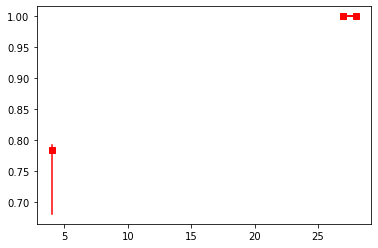

In [30]:
result = 'test_acc'
for i, lamb in enumerate(lambs):
    plt.plot(monk_1_original_quartiles['fasttsdt']['n_leaves'][lamb][1], monk_1_original_quartiles['fasttsdt'][result][lamb][1], marker='s', color='r')
    plt.plot([monk_1_original_quartiles['fasttsdt']['n_leaves'][lamb][1], monk_1_original_quartiles['fasttsdt']['n_leaves'][lamb][1]], 
            [monk_1_original_quartiles['fasttsdt'][result][lamb][0], monk_1_original_quartiles['fasttsdt'][result][lamb][2]], color='r')
    plt.plot([monk_1_original_quartiles['fasttsdt']['n_leaves'][lamb][0], monk_1_original_quartiles['fasttsdt']['n_leaves'][lamb][2]], 
            [monk_1_original_quartiles['fasttsdt'][result][lamb][1], monk_1_original_quartiles['fasttsdt'][result][lamb][1]], color='r')
        
plt.show()

### Drop Last

In [15]:
prob = '_last_'
monk_1_last_quartiles = construct(prob, monk_1)

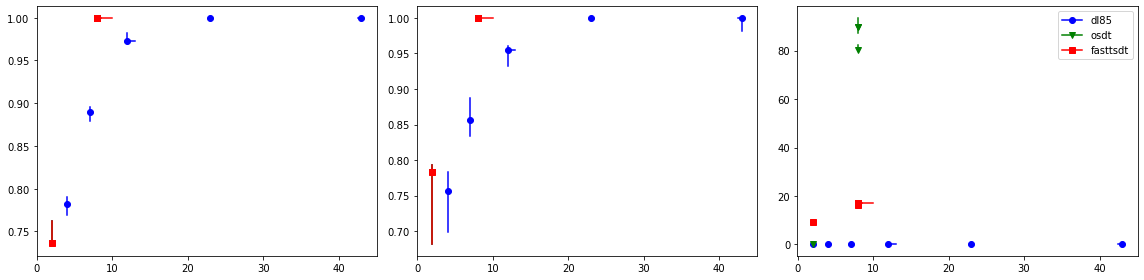

In [16]:
fig, axs = plt.subplots(1, 3, figsize = (16, 4))
plot_restuls(monk_1_last_quartiles, 'train_acc', depths, lambs, axs[0])
plot_restuls(monk_1_last_quartiles, 'test_acc', depths, lambs, axs[1])
plot_restuls(monk_1_last_quartiles, 'times', depths, lambs, axs[2])

plt.legend(handles=legend_elements)
plt.tight_layout()
plt.show()

### Drop First

In [11]:
prob = '_first_'
monk_1_first_quartiles = construct(prob, monk_1)

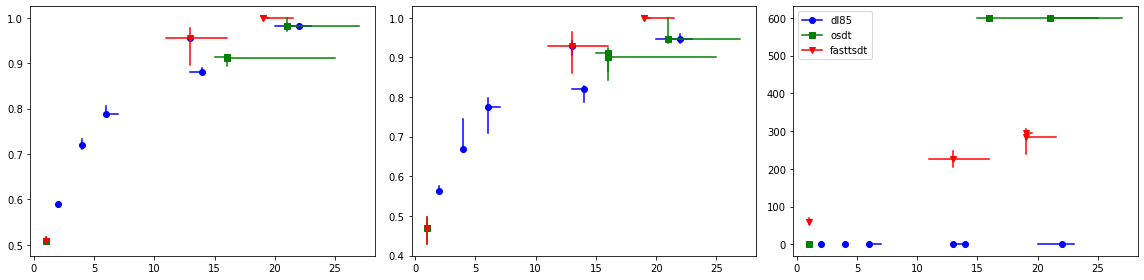

In [12]:
fig, axs = plt.subplots(1, 3, figsize = (16, 4))
plot_restuls(monk_1_first_quartiles, 'train_acc', depths, lambs, axs[0])
plot_restuls(monk_1_first_quartiles, 'test_acc', depths, lambs, axs[1])
plot_restuls(monk_1_first_quartiles, 'times', depths, lambs, axs[2])

plt.legend(handles=legend_elements)
plt.tight_layout()
plt.show()

## Loading the results for Monk 2

In [13]:
monk_2 = {}
directory = 'monk_2/'
for file_name_full in os.listdir(directory):
    with open(directory + file_name_full, 'rb') as file:
        result = pkl.load(file)
        
    file_name = file_name_full.split('.')[0]
    monk_2[file_name] = result

In [14]:
depths = range(1, 7)
lambs = [0.1, 0.01, 0.0025, 0.0001]

In [15]:
prob = '_'
monk_2_quartiles = construct(prob, monk_2)

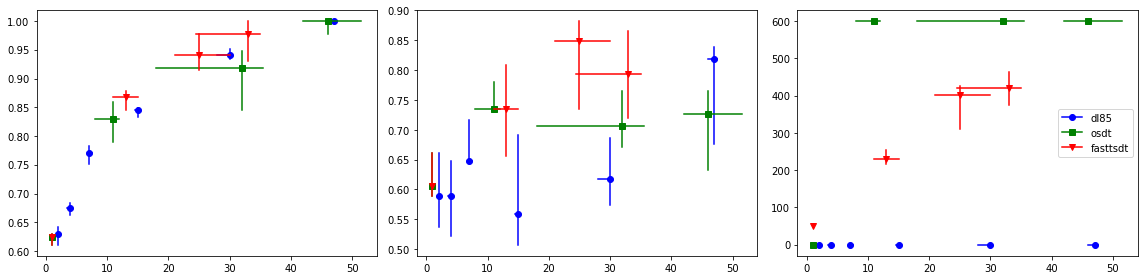

In [16]:
fig, axs = plt.subplots(1, 3, figsize = (16, 4))
plot_restuls(monk_2_quartiles, 'train_acc', depths, lambs, axs[0])
plot_restuls(monk_2_quartiles, 'test_acc', depths, lambs, axs[1])
plot_restuls(monk_2_quartiles, 'times', depths, lambs, axs[2])

plt.legend(handles=legend_elements)
plt.tight_layout()
plt.show()

## Loading the results for Monk 3

In [17]:
monk_3 = {}
directory = 'monk_3/'
for file_name_full in os.listdir(directory):
    with open(directory + file_name_full, 'rb') as file:
        result = pkl.load(file)
        
    file_name = file_name_full.split('.')[0]
    monk_3[file_name] = result

In [18]:
depths = range(1, 7)
lambs = [0.1, 0.01, 0.0025, 0.0001]

In [19]:
prob = '_'
monk_3_quartiles = construct(prob, monk_3)

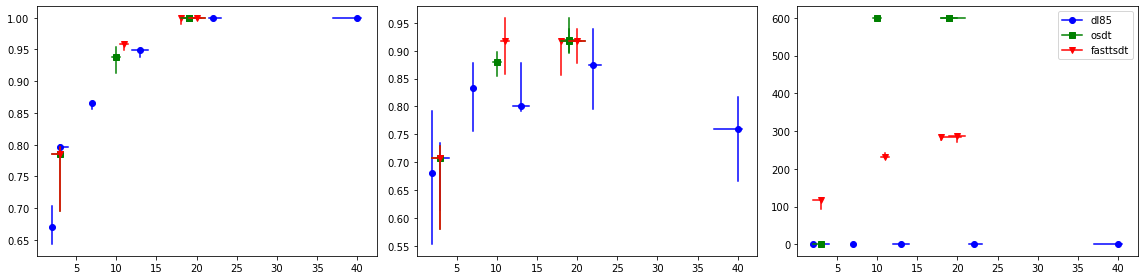

In [20]:
fig, axs = plt.subplots(1, 3, figsize = (16, 4))
plot_restuls(monk_3_quartiles, 'train_acc', depths, lambs, axs[0])
plot_restuls(monk_3_quartiles, 'test_acc', depths, lambs, axs[1])
plot_restuls(monk_3_quartiles, 'times', depths, lambs, axs[2])

plt.legend(handles=legend_elements)
plt.tight_layout()
plt.show()

## Loading the results for Tic-Tac-Toe

In [43]:
def construct(prob, data):
    d = {'dl85' : {}, 'osdt' : {}, 'fasttsdt' : {}}

    for result in res:
        d['dl85'][result] = {}
        for depth in depths:
            d['dl85'][result][depth] = quantiles(data[result + prob + 'dl85'][depth])

        d['osdt'][result] = {}
        d['fasttsdt'][result] = {}
        for lamb in lambs:
            d['osdt'][result][lamb] = quantiles(data[result + prob + 'osdt'][lamb])
            d['fasttsdt'][result][lamb] = quantiles(data[result + prob + 'fasttsdt'][lamb])
            
    return d

legend_elements = [Line2D([0], [0], marker='o', color='b', label='dl85', markerfacecolor='b'), 
                   Line2D([0], [0], marker='s', color='g', label='osdt', markerfacecolor='g'), 
                   Line2D([0], [0], marker='v', color='r', label='fasttsdt', markerfacecolor='r')]

def plot_restuls(d, result, depths, lambs, ax):
    for i, depth in enumerate(depths):
        ax.plot(d['dl85']['n_leaves'][depth][1], d['dl85'][result][depth][1], marker='o', color='b')
        ax.plot([d['dl85']['n_leaves'][depth][1], d['dl85']['n_leaves'][depth][1]], 
                [d['dl85'][result][depth][0], d['dl85'][result][depth][2]], color='b')
        ax.plot([d['dl85']['n_leaves'][depth][0], d['dl85']['n_leaves'][depth][2]], 
                [d['dl85'][result][depth][1], d['dl85'][result][depth][1]], color='b')

    for i, lamb in enumerate(lambs):
        ax.plot(d['osdt']['n_leaves'][lamb][1], d['osdt'][result][lamb][1], marker='s', color='g')
        ax.plot([d['osdt']['n_leaves'][lamb][1], d['osdt']['n_leaves'][lamb][1]], 
                [d['osdt'][result][lamb][0], d['osdt'][result][lamb][2]], color='g')
        ax.plot([d['osdt']['n_leaves'][lamb][0], d['osdt']['n_leaves'][lamb][2]], 
                [d['osdt'][result][lamb][1], d['osdt'][result][lamb][1]], color='g')


        ax.plot(d['fasttsdt']['n_leaves'][lamb][1], d['fasttsdt'][result][lamb][1], marker='v', color='r')
        ax.plot([d['fasttsdt']['n_leaves'][lamb][1], d['fasttsdt']['n_leaves'][lamb][1]], 
                [d['fasttsdt'][result][lamb][0], d['fasttsdt'][result][lamb][2]], color='r')
        ax.plot([d['fasttsdt']['n_leaves'][lamb][0], d['fasttsdt']['n_leaves'][lamb][2]], 
                [d['fasttsdt'][result][lamb][1], d['fasttsdt'][result][lamb][1]], color='r')

In [21]:
tic_tac_toe = {}
directory = 'tic-tac-toe/'
for file_name_full in os.listdir(directory):
    with open(directory + file_name_full, 'rb') as file:
        result = pkl.load(file)
        
    file_name = file_name_full.split('.')[0]
    tic_tac_toe[file_name] = result

In [22]:
depths = range(1, 7)
lambs = [0.1, 0.01, 0.0025, 0.0001]

In [23]:
prob = '_'
tic_tac_toe_quartiles = construct(prob, tic_tac_toe)

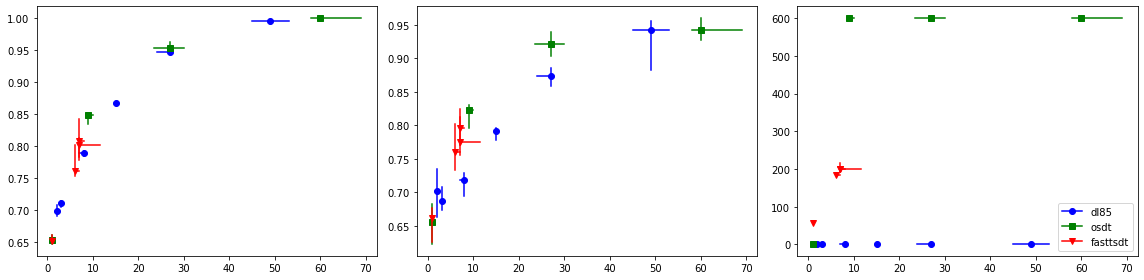

In [24]:
fig, axs = plt.subplots(1, 3, figsize = (16, 4))
plot_restuls(tic_tac_toe_quartiles, 'train_acc', depths, lambs, axs[0])
plot_restuls(tic_tac_toe_quartiles, 'test_acc', depths, lambs, axs[1])
plot_restuls(tic_tac_toe_quartiles, 'times', depths, lambs, axs[2])

plt.legend(handles=legend_elements)
plt.tight_layout()
plt.show()

## Loading the results for Car-Evaluation

In [25]:
car = {}
directory = 'car-evaluation/'
for file_name_full in os.listdir(directory):
    with open(directory + file_name_full, 'rb') as file:
        result = pkl.load(file)
        
    file_name = file_name_full.split('.')[0]
    car[file_name] = result

In [26]:
depths = range(1, 7)
lambs = [0.1, 0.01, 0.0025, 0.0001]

In [27]:
prob = '_'
car_quartiles = construct(prob, car)

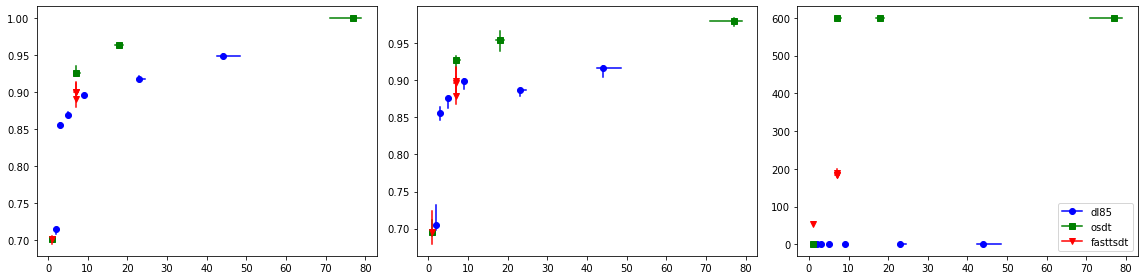

In [28]:
fig, axs = plt.subplots(1, 3, figsize = (16, 4))
plot_restuls(car_quartiles, 'train_acc', depths, lambs, axs[0])
plot_restuls(car_quartiles, 'test_acc', depths, lambs, axs[1])
plot_restuls(car_quartiles, 'times', depths, lambs, axs[2])

plt.legend(handles=legend_elements)
plt.tight_layout()
plt.show()

## Loading the results for COMPAS

In [29]:
compas = {}
directory = 'compas/'
for file_name_full in os.listdir(directory):
    with open(directory + file_name_full, 'rb') as file:
        result = pkl.load(file)
        
    file_name = file_name_full.split('.')[0]
    compas[file_name] = result

In [30]:
depths = range(1, 7)
lambs = [0.1, 0.01, 0.0025, 0.0001]

In [31]:
prob = '_'
compas_quartiles = construct(prob, compas)

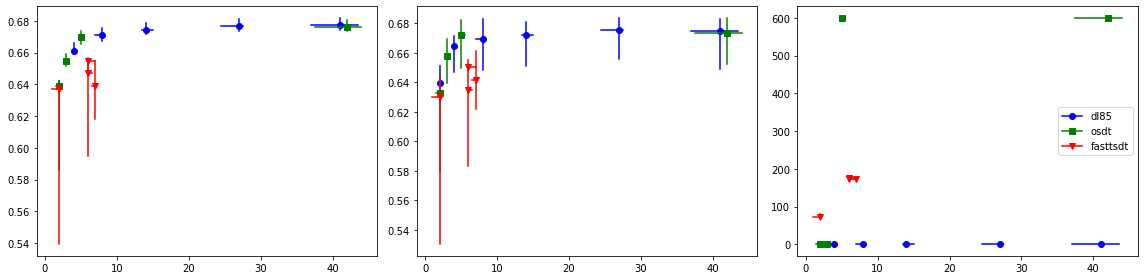

In [32]:
fig, axs = plt.subplots(1, 3, figsize = (16, 4))
plot_restuls(compas_quartiles, 'train_acc', depths, lambs, axs[0])
plot_restuls(compas_quartiles, 'test_acc', depths, lambs, axs[1])
plot_restuls(compas_quartiles, 'times', depths, lambs, axs[2])

plt.legend(handles=legend_elements)
plt.tight_layout()
plt.show()

## Loading the results for FICO

In [33]:
fico = {}
directory = 'fico/'
for file_name_full in os.listdir(directory):
    with open(directory + file_name_full, 'rb') as file:
        result = pkl.load(file)
        
    file_name = file_name_full.split('.')[0]
    fico[file_name] = result

In [34]:
depths = range(1, 7)
lambs = [0.1, 0.01, 0.0025, 0.0001]

In [35]:
prob = '_'
fico_quartiles = construct(prob, fico)

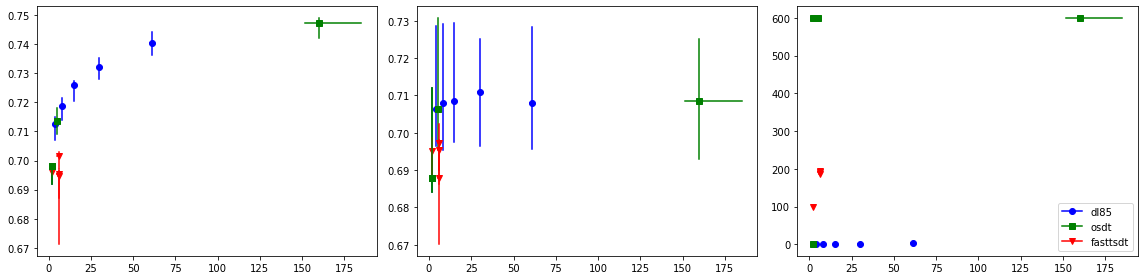

In [36]:
fig, axs = plt.subplots(1, 3, figsize = (16, 4))
plot_restuls(fico_quartiles, 'train_acc', depths, lambs, axs[0])
plot_restuls(fico_quartiles, 'test_acc', depths, lambs, axs[1])
plot_restuls(fico_quartiles, 'times', depths, lambs, axs[2])

plt.legend(handles=legend_elements)
plt.tight_layout()
plt.show()

## Concluding Figures

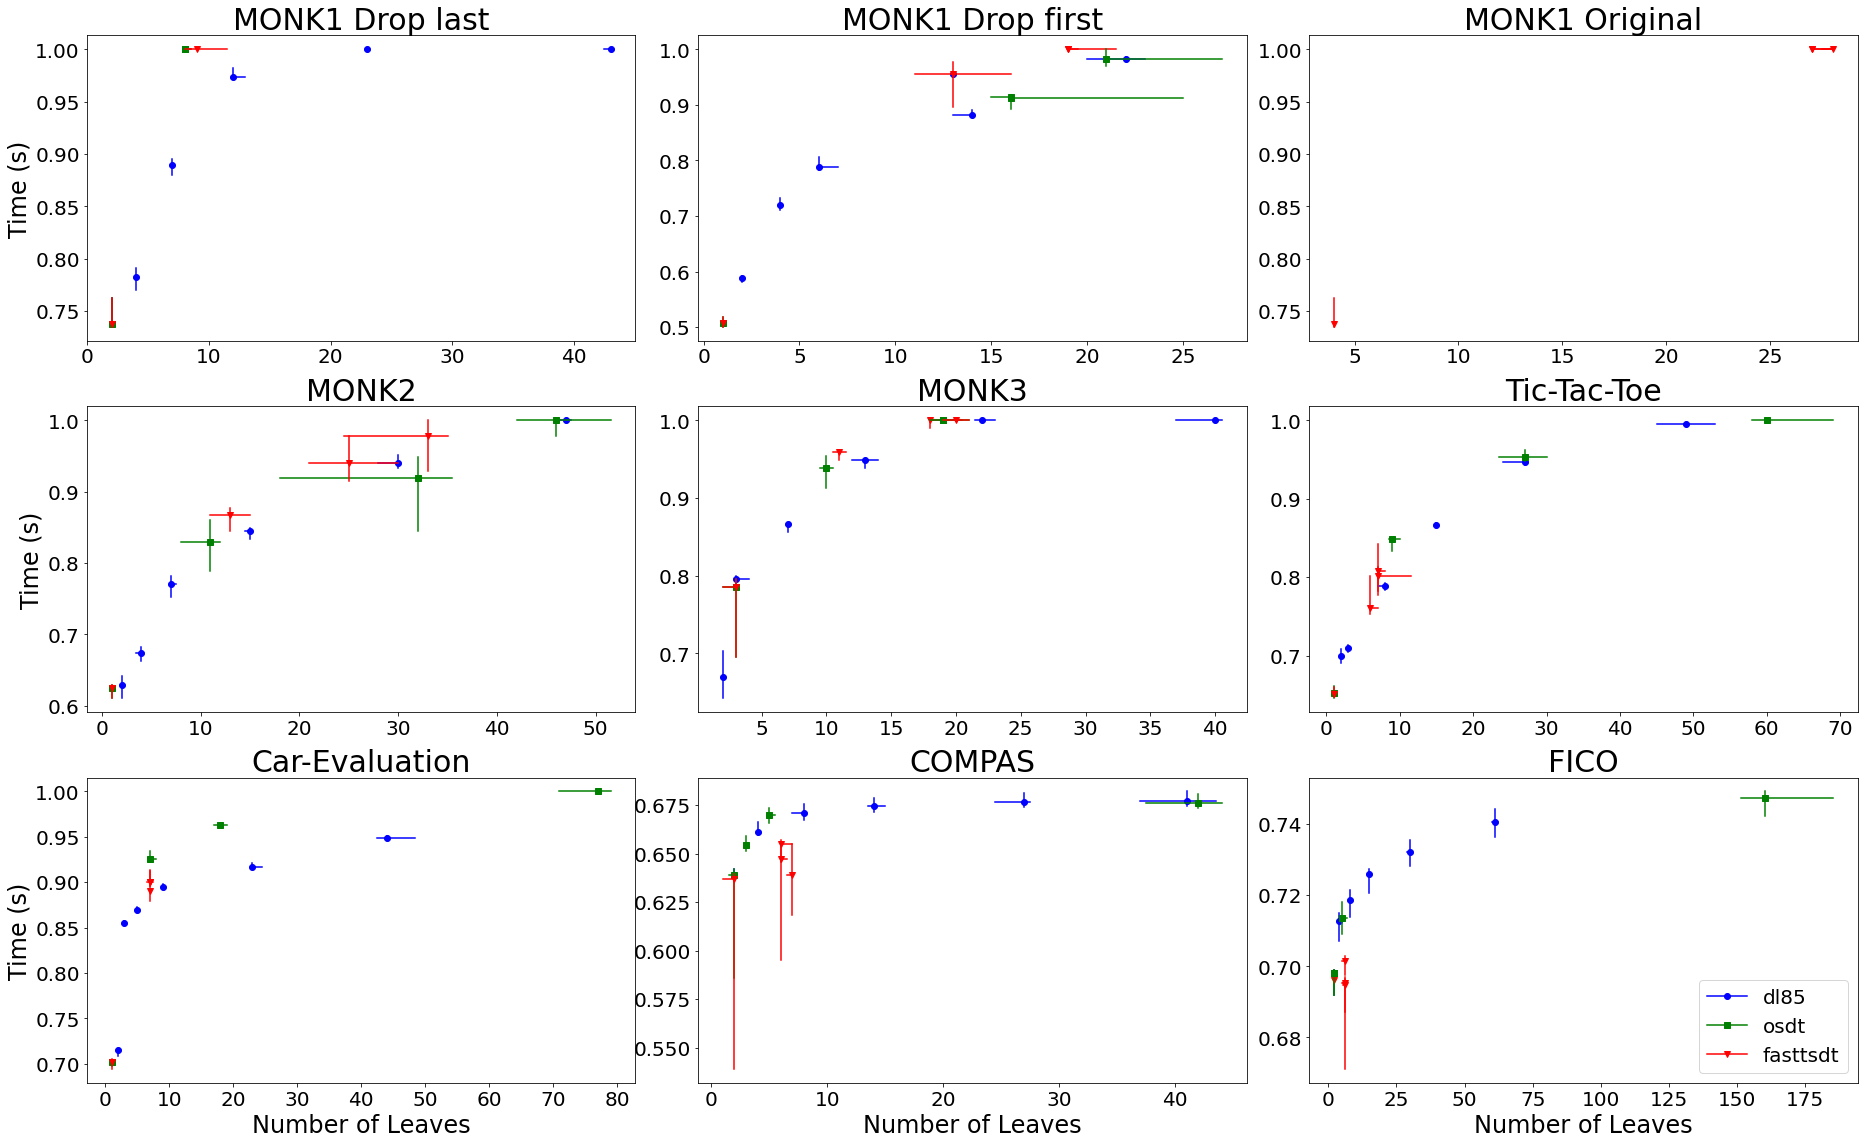

In [37]:
fig, axs = plt.subplots(3, 3, figsize=(26, 16))

prob = 'train_acc'

depths = range(1, 7)
lambs = [0.1, 0.01, 0.0025, 0.0001]

plot_restuls(monk_1_last_quartiles, prob, depths, lambs, axs[0, 0])
axs[0, 0].set_title('MONK1 Drop last', fontsize=30)
axs[0, 0].set_ylabel('Time (s)', fontsize=24)
axs[0, 0].tick_params(axis='both', labelsize=20)

plot_restuls(monk_1_first_quartiles, prob, depths, lambs, axs[0, 1])
axs[0, 1].set_title('MONK1 Drop first', fontsize=30)
axs[0, 1].tick_params(axis='both', labelsize=20)

for i, lamb in enumerate(lambs):
    axs[0, 2].plot(monk_1_original_quartiles['fasttsdt']['n_leaves'][lamb][1], monk_1_original_quartiles['fasttsdt'][prob][lamb][1], marker='v', color='r')
    axs[0, 2].plot([monk_1_original_quartiles['fasttsdt']['n_leaves'][lamb][1], monk_1_original_quartiles['fasttsdt']['n_leaves'][lamb][1]], 
            [monk_1_original_quartiles['fasttsdt'][prob][lamb][0], monk_1_original_quartiles['fasttsdt'][prob][lamb][2]], color='r')
    axs[0, 2].plot([monk_1_original_quartiles['fasttsdt']['n_leaves'][lamb][0], monk_1_original_quartiles['fasttsdt']['n_leaves'][lamb][2]], 
            [monk_1_original_quartiles['fasttsdt'][prob][lamb][1], monk_1_original_quartiles['fasttsdt'][prob][lamb][1]], color='r')
    
axs[0, 2].set_title('MONK1 Original', fontsize=30)
axs[0, 2].tick_params(axis='both', labelsize=20)

depths = range(1, 7)
lambs = [0.1, 0.01, 0.0025, 0.0001]

plot_restuls(monk_2_quartiles, prob, depths, lambs, axs[1, 0])
axs[1, 0].set_title('MONK2', fontsize=30)
axs[1, 0].set_ylabel('Time (s)', fontsize=24)
axs[1, 0].tick_params(axis='both', labelsize=20)

plot_restuls(monk_3_quartiles, prob, depths, lambs, axs[1, 1])
axs[1, 1].set_title('MONK3', fontsize=30)
axs[1, 1].tick_params(axis='both', labelsize=20)

plot_restuls(tic_tac_toe_quartiles, prob, depths, lambs, axs[1, 2])
axs[1, 2].set_title('Tic-Tac-Toe', fontsize=30)
axs[1, 2].tick_params(axis='both', labelsize=20)

plot_restuls(car_quartiles, prob, depths, lambs, axs[2, 0])
axs[2, 0].set_title('Car-Evaluation', fontsize=30)
axs[2, 0].set_ylabel('Time (s)', fontsize=24)
axs[2, 0].set_xlabel('Number of Leaves', fontsize=24)
axs[2, 0].tick_params(axis='both', labelsize=20)

plot_restuls(compas_quartiles, prob, depths, lambs, axs[2, 1])
axs[2, 1].set_title('COMPAS', fontsize=30)
axs[2, 1].set_xlabel('Number of Leaves', fontsize=24)
axs[2, 1].tick_params(axis='both', labelsize=20)

plot_restuls(fico_quartiles, prob, depths, lambs, axs[2, 2])
axs[2, 2].set_title('FICO', fontsize=30)
axs[2, 2].set_xlabel('Number of Leaves', fontsize=24)
axs[2, 2].tick_params(axis='both', labelsize=20)

plt.legend(handles=legend_elements, loc='lower right', fontsize=20)
plt.tight_layout()
plt.savefig('train_accuracies.png')
plt.show()

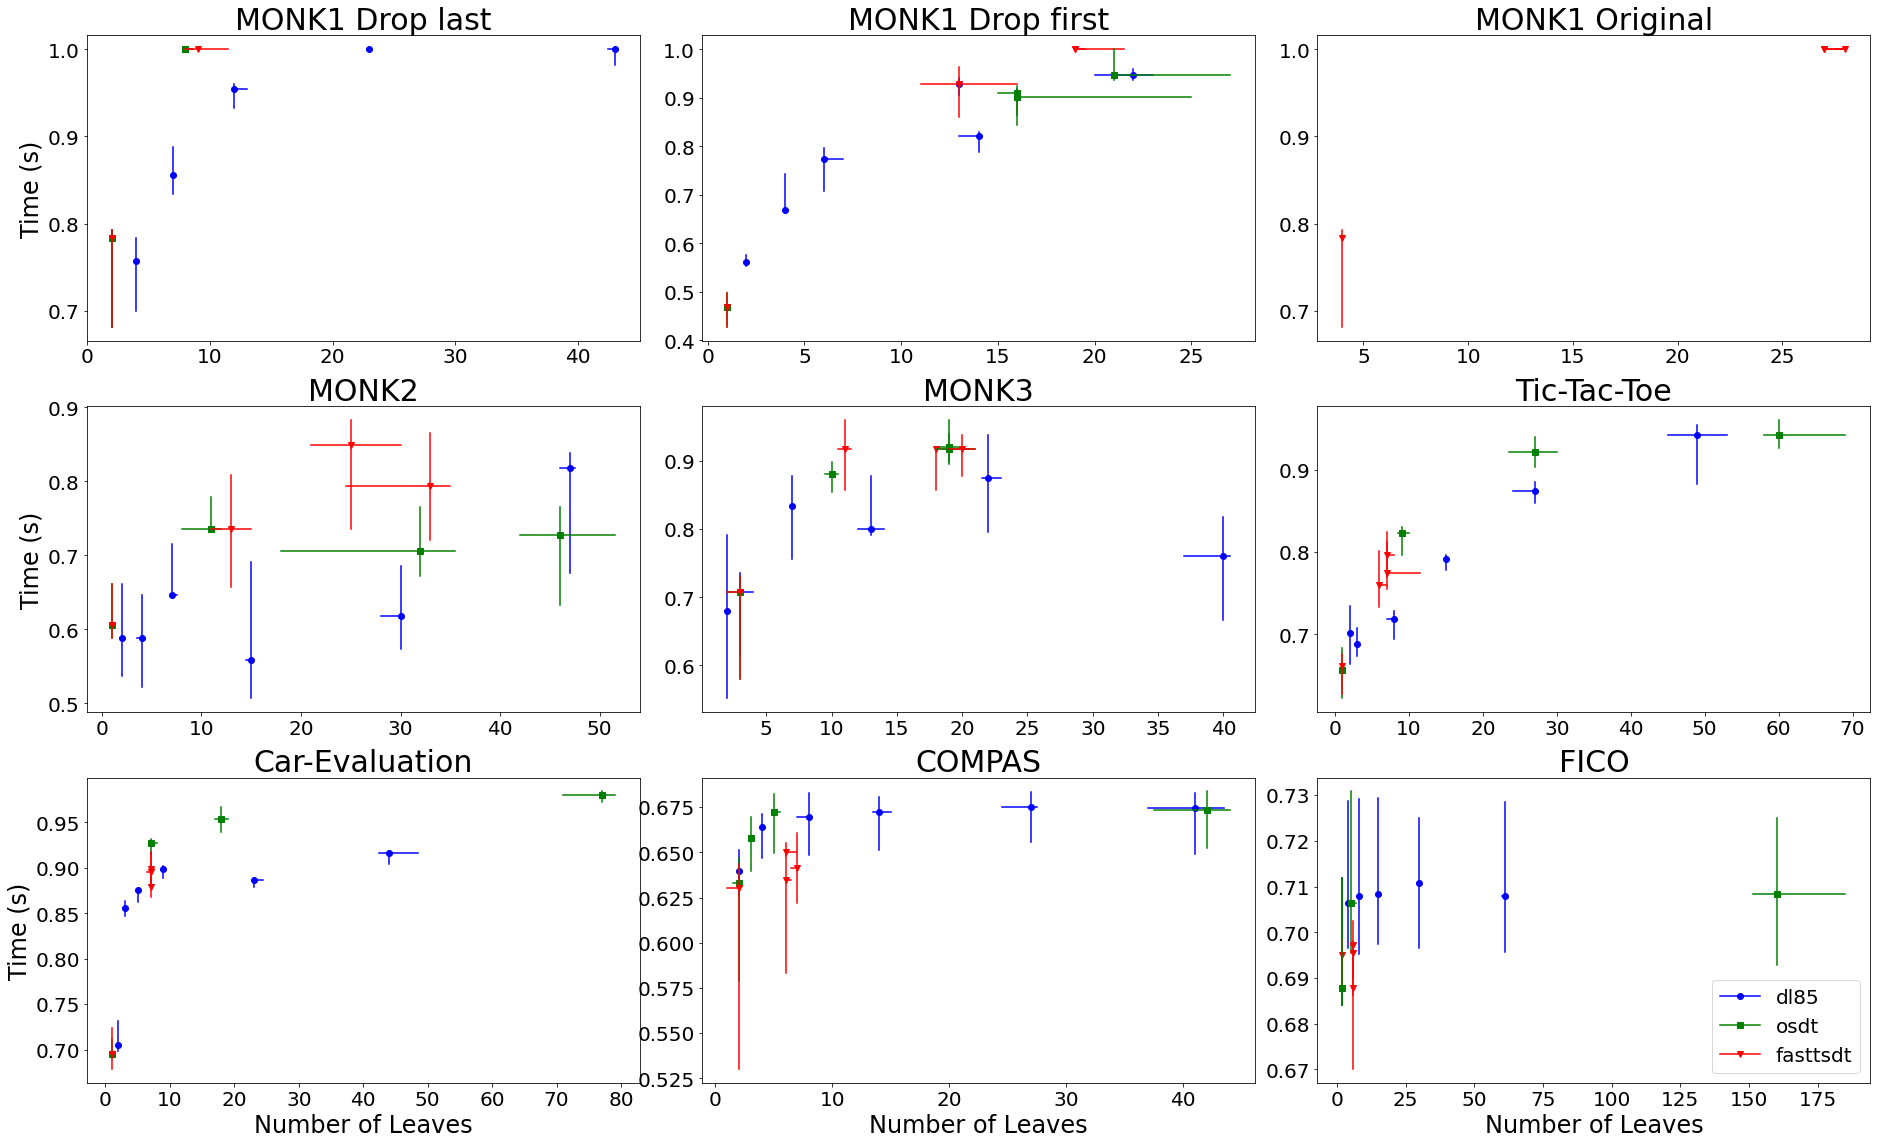

In [38]:
fig, axs = plt.subplots(3, 3, figsize=(26, 16))

prob = 'test_acc'

depths = range(1, 7)
lambs = [0.1, 0.01, 0.0025, 0.0001]

plot_restuls(monk_1_last_quartiles, prob, depths, lambs, axs[0, 0])
axs[0, 0].set_title('MONK1 Drop last', fontsize=30)
axs[0, 0].set_ylabel('Time (s)', fontsize=24)
axs[0, 0].tick_params(axis='both', labelsize=20)

plot_restuls(monk_1_first_quartiles, prob, depths, lambs, axs[0, 1])
axs[0, 1].set_title('MONK1 Drop first', fontsize=30)
axs[0, 1].tick_params(axis='both', labelsize=20)

for i, lamb in enumerate(lambs):
    axs[0, 2].plot(monk_1_original_quartiles['fasttsdt']['n_leaves'][lamb][1], monk_1_original_quartiles['fasttsdt'][prob][lamb][1], marker='v', color='r')
    axs[0, 2].plot([monk_1_original_quartiles['fasttsdt']['n_leaves'][lamb][1], monk_1_original_quartiles['fasttsdt']['n_leaves'][lamb][1]], 
            [monk_1_original_quartiles['fasttsdt'][prob][lamb][0], monk_1_original_quartiles['fasttsdt'][prob][lamb][2]], color='r')
    axs[0, 2].plot([monk_1_original_quartiles['fasttsdt']['n_leaves'][lamb][0], monk_1_original_quartiles['fasttsdt']['n_leaves'][lamb][2]], 
            [monk_1_original_quartiles['fasttsdt'][prob][lamb][1], monk_1_original_quartiles['fasttsdt'][prob][lamb][1]], color='r')
    
axs[0, 2].set_title('MONK1 Original', fontsize=30)
axs[0, 2].tick_params(axis='both', labelsize=20)

depths = range(1, 7)
lambs = [0.1, 0.01, 0.0025, 0.0001]

plot_restuls(monk_2_quartiles, prob, depths, lambs, axs[1, 0])
axs[1, 0].set_title('MONK2', fontsize=30)
axs[1, 0].set_ylabel('Time (s)', fontsize=24)
axs[1, 0].tick_params(axis='both', labelsize=20)

plot_restuls(monk_3_quartiles, prob, depths, lambs, axs[1, 1])
axs[1, 1].set_title('MONK3', fontsize=30)
axs[1, 1].tick_params(axis='both', labelsize=20)

plot_restuls(tic_tac_toe_quartiles, prob, depths, lambs, axs[1, 2])
axs[1, 2].set_title('Tic-Tac-Toe', fontsize=30)
axs[1, 2].tick_params(axis='both', labelsize=20)

plot_restuls(car_quartiles, prob, depths, lambs, axs[2, 0])
axs[2, 0].set_title('Car-Evaluation', fontsize=30)
axs[2, 0].set_ylabel('Time (s)', fontsize=24)
axs[2, 0].set_xlabel('Number of Leaves', fontsize=24)
axs[2, 0].tick_params(axis='both', labelsize=20)

plot_restuls(compas_quartiles, prob, depths, lambs, axs[2, 1])
axs[2, 1].set_title('COMPAS', fontsize=30)
axs[2, 1].set_xlabel('Number of Leaves', fontsize=24)
axs[2, 1].tick_params(axis='both', labelsize=20)

plot_restuls(fico_quartiles, prob, depths, lambs, axs[2, 2])
axs[2, 2].set_title('FICO', fontsize=30)
axs[2, 2].set_xlabel('Number of Leaves', fontsize=24)
axs[2, 2].tick_params(axis='both', labelsize=20)

plt.legend(handles=legend_elements, loc='lower right', fontsize=20)
plt.tight_layout()
plt.savefig('test_accuracies.png')
plt.show()

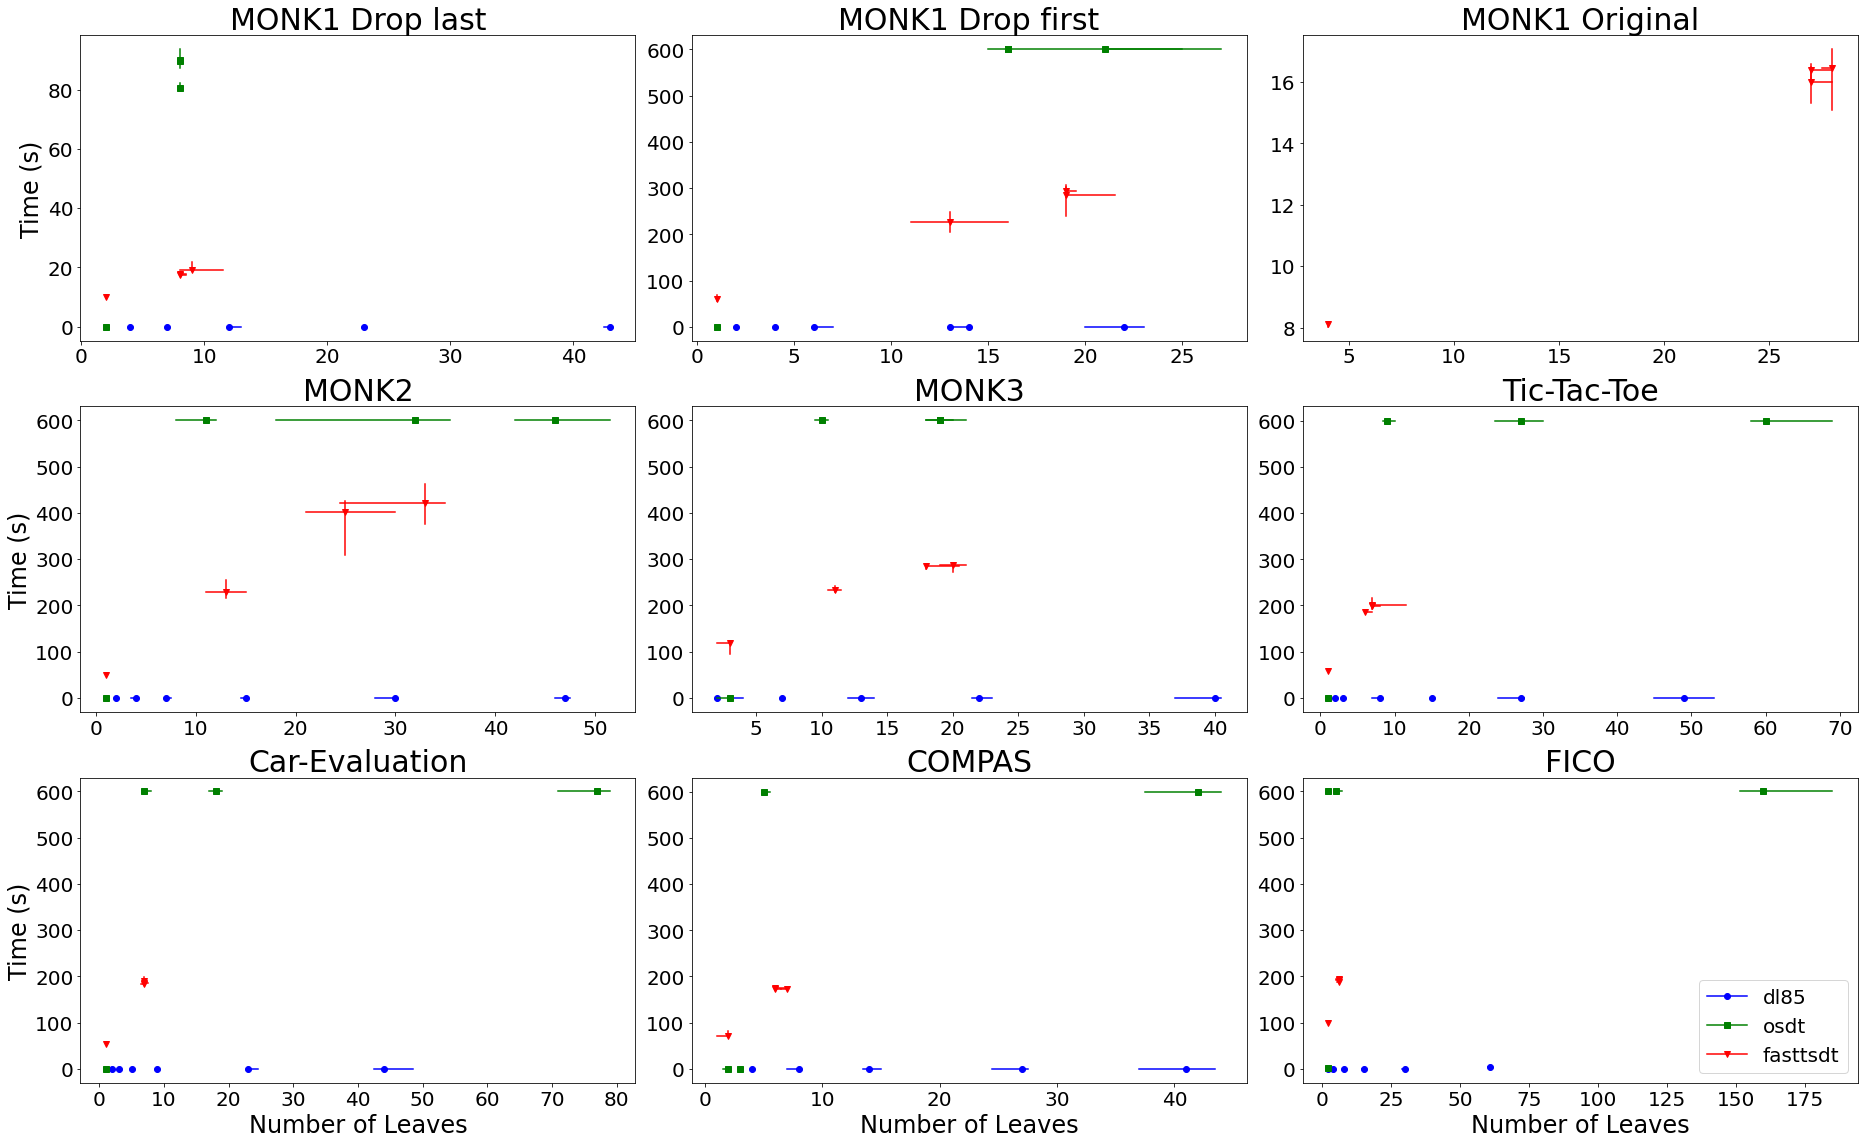

In [39]:
fig, axs = plt.subplots(3, 3, figsize=(26, 16))

prob = 'times'

depths = range(1, 7)
lambs = [0.1, 0.01, 0.0025, 0.0001]

plot_restuls(monk_1_last_quartiles, prob, depths, lambs, axs[0, 0])
axs[0, 0].set_title('MONK1 Drop last', fontsize=30)
axs[0, 0].set_ylabel('Time (s)', fontsize=24)
axs[0, 0].tick_params(axis='both', labelsize=20)

plot_restuls(monk_1_first_quartiles, prob, depths, lambs, axs[0, 1])
axs[0, 1].set_title('MONK1 Drop first', fontsize=30)
axs[0, 1].tick_params(axis='both', labelsize=20)

for i, lamb in enumerate(lambs):
    axs[0, 2].plot(monk_1_original_quartiles['fasttsdt']['n_leaves'][lamb][1], monk_1_original_quartiles['fasttsdt'][prob][lamb][1], marker='v', color='r')
    axs[0, 2].plot([monk_1_original_quartiles['fasttsdt']['n_leaves'][lamb][1], monk_1_original_quartiles['fasttsdt']['n_leaves'][lamb][1]], 
            [monk_1_original_quartiles['fasttsdt'][prob][lamb][0], monk_1_original_quartiles['fasttsdt'][prob][lamb][2]], color='r')
    axs[0, 2].plot([monk_1_original_quartiles['fasttsdt']['n_leaves'][lamb][0], monk_1_original_quartiles['fasttsdt']['n_leaves'][lamb][2]], 
            [monk_1_original_quartiles['fasttsdt'][prob][lamb][1], monk_1_original_quartiles['fasttsdt'][prob][lamb][1]], color='r')
    
axs[0, 2].set_title('MONK1 Original', fontsize=30)
axs[0, 2].tick_params(axis='both', labelsize=20)

depths = range(1, 7)
lambs = [0.1, 0.01, 0.0025, 0.0001]

plot_restuls(monk_2_quartiles, prob, depths, lambs, axs[1, 0])
axs[1, 0].set_title('MONK2', fontsize=30)
axs[1, 0].set_ylabel('Time (s)', fontsize=24)
axs[1, 0].tick_params(axis='both', labelsize=20)

plot_restuls(monk_3_quartiles, prob, depths, lambs, axs[1, 1])
axs[1, 1].set_title('MONK3', fontsize=30)
axs[1, 1].tick_params(axis='both', labelsize=20)

plot_restuls(tic_tac_toe_quartiles, prob, depths, lambs, axs[1, 2])
axs[1, 2].set_title('Tic-Tac-Toe', fontsize=30)
axs[1, 2].tick_params(axis='both', labelsize=20)

plot_restuls(car_quartiles, prob, depths, lambs, axs[2, 0])
axs[2, 0].set_title('Car-Evaluation', fontsize=30)
axs[2, 0].set_ylabel('Time (s)', fontsize=24)
axs[2, 0].set_xlabel('Number of Leaves', fontsize=24)
axs[2, 0].tick_params(axis='both', labelsize=20)

plot_restuls(compas_quartiles, prob, depths, lambs, axs[2, 1])
axs[2, 1].set_title('COMPAS', fontsize=30)
axs[2, 1].set_xlabel('Number of Leaves', fontsize=24)
axs[2, 1].tick_params(axis='both', labelsize=20)

plot_restuls(fico_quartiles, prob, depths, lambs, axs[2, 2])
axs[2, 2].set_title('FICO', fontsize=30)
axs[2, 2].set_xlabel('Number of Leaves', fontsize=24)
axs[2, 2].tick_params(axis='both', labelsize=20)

plt.legend(handles=legend_elements, loc='lower right', fontsize=20)
plt.tight_layout()
plt.savefig('times.png')
plt.show()